# EDA dan Klasifikasi untuk Memprediksi Nilai Order #


## Kelompok 6 Ilmu Komputer Kelas C2 ##
1. Naufal Fakhri Al-Najieb (2309648)
2. Abdurrahman Rauf Budiman (2301102)
3. Haniel Septian Putra Alren (2310978)
4. Muhammad Radhi Maulana (2311119)
5. Yoga Ilham Prasetio (2304539)

## Pendahuluan


Pada laporan ini, kami melakukan EDA dan Klasifikasi berdasarkan dataset dari website Data Mining Cup 2013 (https://www.data-mining-cup.com/reviews/dmc-2013/) yang diakses pada tanggal 14 November 2024. Dengan data ini, analisis dilakukan untuk memahami pola transaksi pelanggan, kecenderungan pembelian, serta faktor-faktor yang mungkin memengaruhi keputusan pelanggan untuk membatalkan langganan mereka.

## Praproses Data

Menyiapkan dan mengolah data untuk memastikan data yang digunakan bersih, konsisten, dan siap untuk dilakukan analisis (EDA) lebih lanjut serta siap digunakan untuk model dataset (klasifikasi).

### 1. Load Dataset

In [436]:
#Load Dataset EDA and Praprocess
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Load Dataset Klasifikasi
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from xgboost import XGBClassifier
from xgboost import plot_importance


#Load Dataset Save model file
import pickle
import joblib

In [437]:
#Load Dataset
data_train = pd.read_table("transact_train.txt", sep='|')
data_class = pd.read_table("transact_class.txt", sep='|')

### 2. Pembersihan Data

**Pembersihan Data Untuk EDA dan Klasifikasi:**

Mengganti data yang mengandung '?' menjadi 0

In [438]:
data_train.replace('?', 0, inplace=True)

### 3. Transformasi Data

**1. Menyiapkan Data Untuk EDA Visualisasi ke-1**

Disini data disiapkan untuk Visualisasi pertama

In [439]:
# Menyiapkan data visualisasi untuk EDA
df_train_EDA_1 = data_train.copy()
df_train_EDA_1 = df_train_EDA_1.dropna().reset_index(drop=True)
df_train_EDA_1 = df_train_EDA_1.loc[:, ['duration', 'order']]

# Mapping dan Groupby nilai order
df_train_EDA_1['order_mapped'] = df_train_EDA_1['order'].map({0: 'n', 1: 'y'})
order_counts = df_train_EDA_1.groupby(['duration', 'order_mapped']).size().reset_index(name='count')
df_train_EDA_1['order_mapped'] = df_train_EDA_1['order'].map({'y': 'Yes', 'n': 'No'})

# Pastikan max duration diubah ke integer
max_duration = int(df_train_EDA_1['duration'].max())
df_train_EDA_1['duration_group'] = pd.cut(df_train_EDA_1['duration'], bins=range(0, max_duration + 1000, 1000), right=False)

# Groupby berdasarkan durasi dan 'order_mapped'
order_counts = df_train_EDA_1.groupby(['duration_group', 'order_mapped'], observed=False).size().reset_index(name='count')


**2. Menyiapkan Data Untuk EDA Visualisasi ke-2**

Disini data disiapkan untuk Visualisasi kedua

In [440]:
# Menyiapkan data visualisasi untuk EDA
df_train_EDA_2 = data_train.copy()
df_train_EDA_2 = df_train_EDA_2.loc[:,['startHour', 'duration']]
df_train_EDA_2 = df_train_EDA_2.dropna().reset_index(drop=True)

# Tambahkan kolom untuk rata-rata durasi
df_train_EDA_2['duration_avg'] = df_train_EDA_2['duration'].mean()

# Grupkan data berdasarkan startHour
grouped_df = df_train_EDA_2.groupby('startHour').agg({'duration': 'mean'}).reset_index()
grouped_df.rename(columns={'duration': 'duration_avg'}, inplace=True)

# Pivot data untuk plotting
pivot_data2 = grouped_df.pivot(index='startHour', columns='duration_avg', values='duration_avg')
pivot_data2 = grouped_df.set_index('startHour')  # Menjadikan startHour sebagai index
pivot_data2.fillna(0, inplace=True)

**3. Menyiapkan Data Untuk EDA Visualisasi ke-3**

Disini data disiapkan untuk Visualisasi ketiga

In [441]:
# Menyiapkan data visualisasi untuk EDA
df_train_EDA_3 = data_train.copy()
df_train_EDA_3 = df_train_EDA_3.loc[:,['cCount', 'bCount', 'order']]
df_train_EDA_3 = df_train_EDA_3.dropna().reset_index(drop=True)

# Tambahkan kolom untuk rata-rata durasi
df_train_EDA_3['order_mapped'] = df_train_EDA_3['order'].map({'y': 'Yes', 'n': 'No'})

# Grupkan data berdasarkan cCount dan order, lalu hitung rata-rata bCount
grouped_data = df_train_EDA_3.groupby('order').agg({'cCount': 'sum', 'bCount': 'sum'}).reset_index()

grouped_data['bCount'] /= 1000
grouped_data['cCount'] /= 1000

**4. Membuat One Hot Encoding Untuk Klasifikasi**

Disini kita mengubah fitur yang bukan numeric menjadi numeric dengan one hot encoding

In [442]:
# Membuat One hot Encoding
df_train = data_train.copy()
df_train = pd.get_dummies(data=df_train, 
                          columns=['availability','onlineStatus'])

# Membuat LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(df_train['order'])
Y = le.transform(df_train['order'])
X = df_train.drop("order", axis=1)  # Buang kolom 'order' dari atribut training

# Konvert non-numeric columns to numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

**5. Split Data Untuk Klasifikasi**

Disini kita membagi data menjadi data training (untuk melatih model) dan data testing (untuk memvalidasi model)

In [443]:
# Data di split buat training dan validasi
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) adalah pendekatan analisis data awal yang berfokus pada teknik visualisasi dan statistik deskriptif untuk memahami struktur, pola, dan anomali dalam data tanpa membuat asumsi awal (NIST/SEMATECH, 2012).

Tujuan utama kami membuat EDA adalah untuk menggali wawasan dari data, menemukan anomali, dan mempersiapkan data untuk analisis atau pemodelan selanjutnya. 

### 1. Eksplorasi Atribut 

In [444]:
data_train.index += 1
data_train.head().T

,1,2,3,4,5
sessionNo,1,1,1,2,2
startHour,6,6,6,6,6
startWeekday,5,5,5,5,5
duration,0.0,11.94,39.887,0.0,15.633
cCount,1,1,1,0,0
cMinPrice,59.99,59.99,59.99,0,0
cMaxPrice,59.99,59.99,59.99,0,0
cSumPrice,59.99,59.99,59.99,0,0
bCount,1,1,1,0,0
bMinPrice,59.99,59.99,59.99,0,0


### Penjelasan Field Keseluruhan

| Nama Kolom | Definisi |
| --- | --- |
| sessionNo | Nomor sesi yang merepresentasikan ID unik untuk setiap interaksi pelanggan dengan sistem |      
| startHour | Jam mulai sesi dalam format 24 jam. Mencerminkan waktu awal interaksi pelanggan |    
| startWeekday | Hari dalam seminggu ketika sesi dimulai, biasanya dalam format teks atau angka |     
| duration | Durasi sesi dalam satuan waktu tertentu, seperti menit atau detik |  
| cCount | Jumlah klik (click count) yang dilakukan selama sesi tersebut |    
| cMinPrice | Harga terendah dari produk yang di-klik selama sesi |   
| cMaxPrice | Harga tertinggi dari produk yang di-klik selama sesi |  
| cSumPrice | Total harga dari semua produk yang di-klik selama sesi |  
| bCount | Jumlah produk yang dimasukkan ke dalam keranjang belanja selama sesi berlangsung |    
| bMinPrice | Harga terendah dari produk yang dimasukkan ke keranjang selama sesi |    
| bMaxPrice | Harga tertinggi dari produk yang dimasukkan ke keranjang selama sesi |   
| bSumPrice | Total harga dari semua produk yang dimasukkan ke keranjang selama sesi |  
| bStep | Langkah terakhir yang diambil dalam proses belanja, misalnya memasukkan ke keranjang atau melakukan pembayaran |   
| onlineStatus | Status apakah pelanggan sedang online selama sesi berlangsung |   
| availability | Ketersediaan produk yang dilihat atau dibeli pelanggan selama sesi |   
| customerNo | Nomor identifikasi unik pelanggan yang berinteraksi dalam sesi tersebut |   
| maxVal | Nilai maksimum tertentu terkait sesi atau pelanggan |   
| customerScore | Skor yang merepresentasikan nilai atau prioritas pelanggan berdasarkan analisis tertentu |   
| accountLifetime | Lama waktu (hari) sejak akun pelanggan dibuat hingga saat sesi berlangsung |   
| payments | Jumlah pembayaran yang telah dilakukan oleh pelanggan selama mereka menjadi pelanggan | 
| age | Usia pelanggan | 
| address | Informasi alamat pelanggan, biasanya berupa area geografis atau negara asal mereka |   
| lastOrder | Waktu atau durasi sejak pesanan terakhir dilakukan oleh pelanggan hingga sesi saat ini |
| Order | Indikator apakah pelanggan melakukan pemesanan selama sesi tersebut (contoh: yes = melakukan pesanan, no = tidak melakukan pesanan) | 


### Analisis dan Visualisasi Data

**1. Visualisasi Relasi Fitur Durasi (dalam detik) dengan jumlah status order**

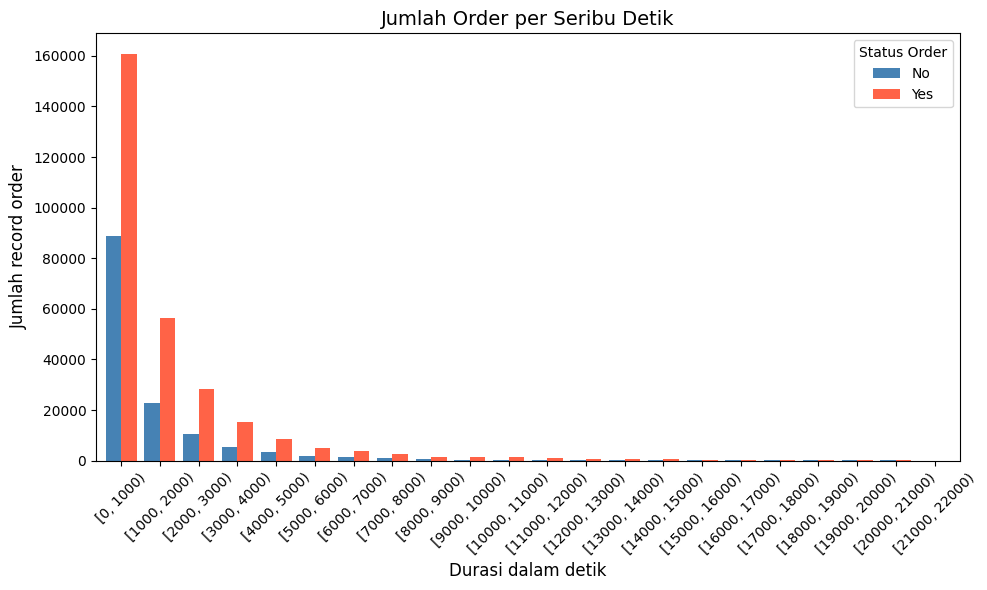

In [445]:
# Pivot data untuk memudahkan visualisasi
pivot_data1 = order_counts.pivot(index='duration_group', columns='order_mapped', values='count').fillna(0)
pivot_data1.plot(kind='bar', figsize=(10, 6), width=0.8, color=['#4682B4', '#FF6347'])

# Tambahkan label dan judul
plt.title('Jumlah Order per Seribu Detik', fontsize=14)
plt.xlabel('Durasi dalam detik', fontsize=12)
plt.ylabel('Jumlah record order', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Status Order', fontsize=10)
plt.tight_layout()

# Tampilkan plot
plt.show()

Berdasarkan visualisasi diatas, dapat disimpulkan bahwa:
- Jumlah orang yang melakukan pemesanan sebagian besar lebih banyak daripada jumlah orang yang tidak melakukan pemesanan
- Setelah detik 1000, jumlah orang yang melakukan pemesanan maupun yang tidak melakukan pemesanan menurun
- Semakin bertambahnya durasi maka jumlah pemesanan mau pun yang tidak memesan menurun  

Menurut asumsi kami, jumlah pengguna yang melakukan pemesanan maupun yang tidak melakukan pemesanan cenderung menurun seiring dengan meningkatnya durasi sesi. Hal ini disebabkan oleh semakin lama durasi sesi, semakin sulit bagi pengguna untuk mengambil keputusan, baik untuk memesan maupun memutuskan untuk tidak memesan.  


**2. Visualisasi Relasi Fitur Durasi (dalam detik) dengan jam mulai sesi**

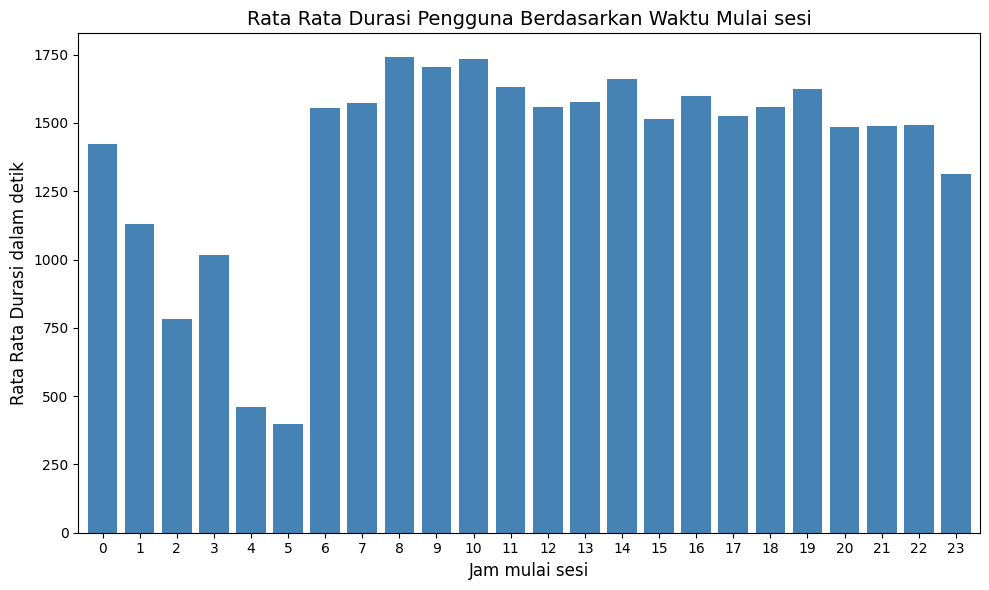

In [461]:
# Plot data
pivot_data2.plot(kind='bar', figsize=(10, 6), width=0.8, color='#4682B4', legend=None)

# Tambahkan label dan judul
plt.title('Rata Rata Durasi Pengguna Berdasarkan Waktu Mulai sesi', fontsize=14)
plt.xlabel('Jam mulai sesi', fontsize=12)
plt.ylabel('Rata Rata Durasi dalam detik', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Tampilkan plot
plt.show()


Berdasarkan visualisasi diatas, dapat disimpulkan bahwa:
- rata-rata durasi waktu penggunaan di jam 6-22, lebih tinggi dibandingkan durasi waktu penggunaan di jam 23-5 
- rentang durasi waktu penggunaan terbanyak terdapat pada jam 8-10
- rentang durasi waktu penggunaan terkecil terdapat pada jam 4-5  

Menurut asumsi kami jumlah pengguna aktif cenderung lebih tinggi pada jam 6-22 karena jam tersebut merupakan waktu produktif atau waktu aktif bagi sebagian besar orang, sehingga durasi penggunaan lebih panjang. Sebaliknya, pada jam 23-5, jumlah pengguna aktif menurun karena merupakan waktu istirahat, sehingga durasi penggunaan lebih singkat.


**3. Visualisasi Relasi Fitur bCount dan cCount dengan jumlah status order**

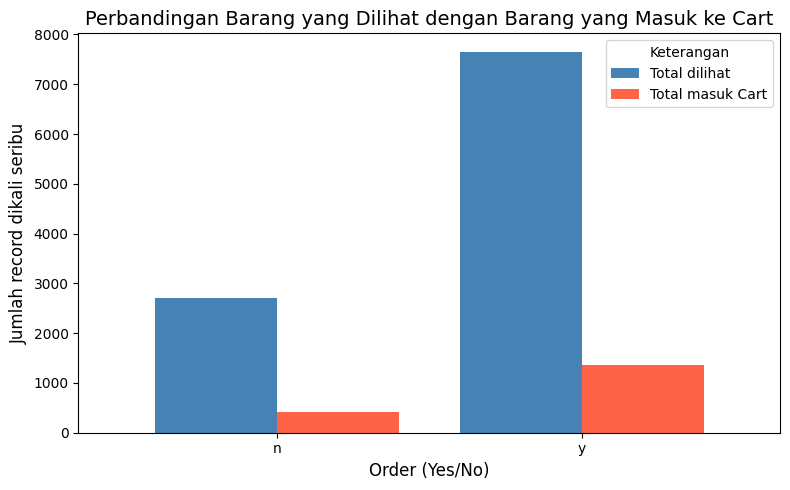

In [447]:
# Plot data
grouped_data.plot(kind='bar',x='order',y=['cCount', 'bCount'],figsize=(8, 5),color=['#4682B4', '#FF6347'],width=0.8)

# Tambahkan label dan judul
plt.title('Perbandingan Barang yang Dilihat dengan Barang yang Masuk ke Cart', fontsize=14)
plt.xlabel('Order (Yes/No)', fontsize=12)
plt.ylabel('Jumlah record dikali seribu', fontsize=12)
plt.xticks(rotation=0)
custom_labels = ['Total dilihat', 'Total masuk Cart']
plt.legend(custom_labels, title='Keterangan', fontsize=10, loc='upper right')
plt.tight_layout()

# Tampilkan plot
plt.show()

Berdasarkan visualisasi diatas, dapat disimpulkan bahwa:
- Total suatu produk dilihat lebih banyak daripada total suatu produk masuk cart
- Total produk dilihat yang akhirnya dibeli lebih banyak dibandingkan total produk dilihat yang akhirnya tidak dibeli
- Total produk masuk cart yang akhirnya dibeli lebih banyak dibandingkan total produk masuk cart yang akhirnya tidak dibeli

Menurut asumsi kami, pengguna cenderung lebih sering melihat suatu produk sebelum memutuskan untuk memasukkannya ke dalam keranjang belanja atau membeli produk tersebut. Hal ini menunjukkan bahwa proses eksplorasi atau perbandingan produk menjadi langkah penting dalam pengambilan keputusan.

## Klasifikasi Data

Di bagian ini, kita akan membuat model menggunakan dataset yang telah di Praproses sebelumnya. Tujuan kita membuat model ini untuk dapat memprediksi order costumer melakukan order atau tidak menggunakan bantuan algoritma machine learning.

### 1. Data Training

**1. Model Training Naive Bayes**

Berikut model training Naive Bayes dengan memperlihatkan confusion matrixnya

In [448]:
# Menjalankan Naive Bayes
# Naive Bayes
NB = MultinomialNB()
NB.fit(X_train, Y_train)
Y_pred = NB.predict(X_test)
acc_NB = accuracy_score(Y_test, Y_pred)

print("Akurasi {}".format(acc_NB))
print(classification_report(Y_test, Y_pred))

Akurasi 0.6890318520331457
              precision    recall  f1-score   support

           0       0.52      0.63      0.57     27770
           1       0.80      0.72      0.76     58033

    accuracy                           0.69     85803
   macro avg       0.66      0.67      0.66     85803
weighted avg       0.71      0.69      0.70     85803



**2. Model Training Decision Tree**

Berikut model training Decision Tree dengan memperlihatkan confusion matrixnya

In [449]:
# Menjalankan Decision Tree
DT = tree.DecisionTreeClassifier(random_state=69)
DT.fit(X_train, Y_train)
Y_pred = DT.predict(X_test)
acc_DT = accuracy_score(Y_test, Y_pred)

print("Akurasi {}".format(acc_DT))
print(classification_report(Y_test, Y_pred))

Akurasi 0.854096010628999
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     27770
           1       0.89      0.89      0.89     58033

    accuracy                           0.85     85803
   macro avg       0.83      0.83      0.83     85803
weighted avg       0.85      0.85      0.85     85803



**3. Model Training Random Forest**

Berikut model training Random Forest dengan memperlihatkan confusion matrixnya

In [450]:
# Menjalankan random Forest
RF = RandomForestClassifier(n_estimators=100, random_state=69, max_depth=30)
RF.fit(X_train, Y_train)
Y_pred = RF.predict(X_test)
acc_RF = accuracy_score(Y_test, Y_pred)
print("Akurasi {}".format(acc_RF))
print(classification_report(Y_test, Y_pred))

Akurasi 0.9123806859900003
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     27770
           1       0.92      0.95      0.94     58033

    accuracy                           0.91     85803
   macro avg       0.91      0.89      0.90     85803
weighted avg       0.91      0.91      0.91     85803



**4. Model Training XGBoost**

Berikut model training XGBoost dengan memperlihatkan confusion matrixnya

In [451]:
# Menjalankan XGBoost
num_classes = len(np.unique(Y_train))

XGB = XGBClassifier(n_estimators=100, max_depth=30, learning_rate=0.1, random_state=6)

XGB.fit(X_train, Y_train)
Y_pred = XGB.predict(X_test)
acc_XGB = accuracy_score(Y_test, Y_pred)

# Mencetak hasil dari XGBoost
print("Akurasi {}".format(acc_XGB))
print(classification_report(Y_test, Y_pred))

Akurasi 0.9270887964290293
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     27770
           1       0.93      0.96      0.95     58033

    accuracy                           0.93     85803
   macro avg       0.92      0.91      0.92     85803
weighted avg       0.93      0.93      0.93     85803



### 2. Perbaikan Kinerja

In [462]:
df_acc = pd.DataFrame({'Naive_Bayes': [acc_NB], 'Decission_Tree': [acc_DT],
                       'Random_Forest': [acc_RF], 'XGBoost' : [acc_XGB]})
df_acc.head()

,Naive_Bayes,Decission_Tree,Random_Forest,XGBoost
0,0.689032,0.854096,0.912381,0.936576


Dari seluruh model training, kami mendapatkan bahwa akurasi yang paling besar dihasilkan oleh XGBoost

**1. Feature Importance dari model Naive Bayes**

Berikut ranking kinerja fitur dari model Naive Bayes

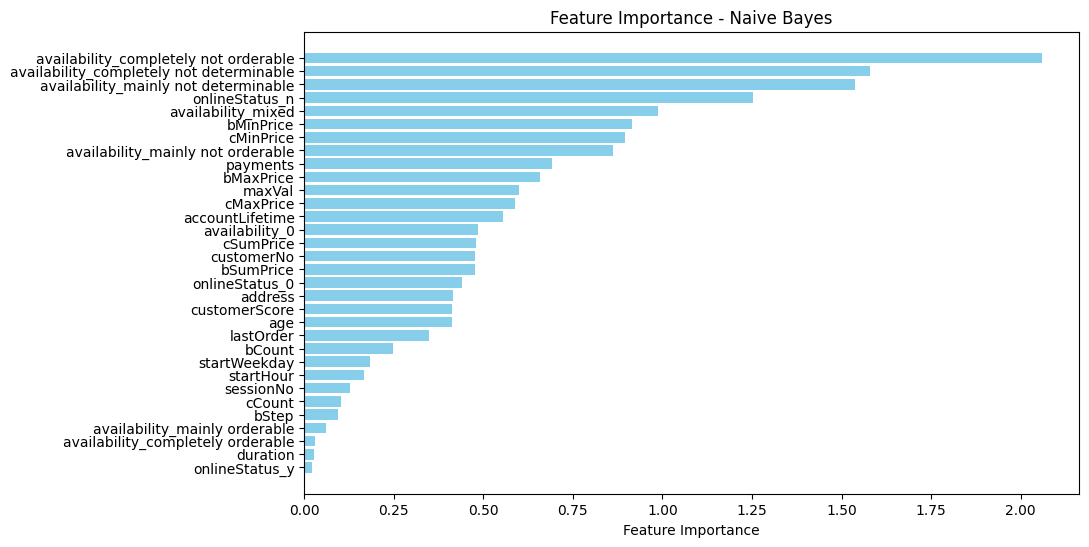

In [453]:
# Feature Importance Naive Bayes
# Ambil log-probabilitas fitur
log_prob = NB.feature_log_prob_

# Hitung perbedaan probabilitas antar kelas (importance)
feature_importance = np.abs(log_prob[1] - log_prob[0])  # Untuk klasifikasi biner
feature_names = X.columns.tolist()

# Urutkan fitur berdasarkan importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance - Naive Bayes")
plt.gca().invert_yaxis()  # Membalik urutan fitur agar fitur penting di atas
plt.show()

Berdasarkan ranking kinerja fitur diatas, dapat disimpulkan bahwa :
- Faktor ketersediaan produk, terutama "completely not orderable" dan "completely not determinable," memiliki pengaruh terbesar terhadap prediksi.
- Harga minimum produk yang di-klik atau dimasukkan ke keranjang (cMinPrice, bMinPrice) serta jumlah pembayaran juga berkontribusi signifikan.
- Durasi sesi dan status online pengguna memiliki pengaruh yang relatif kecil terhadap hasil model. 

**2. Feature Importance dari model Decision Tree**

Berikut ranking kinerja fitur dari model Decision Tree

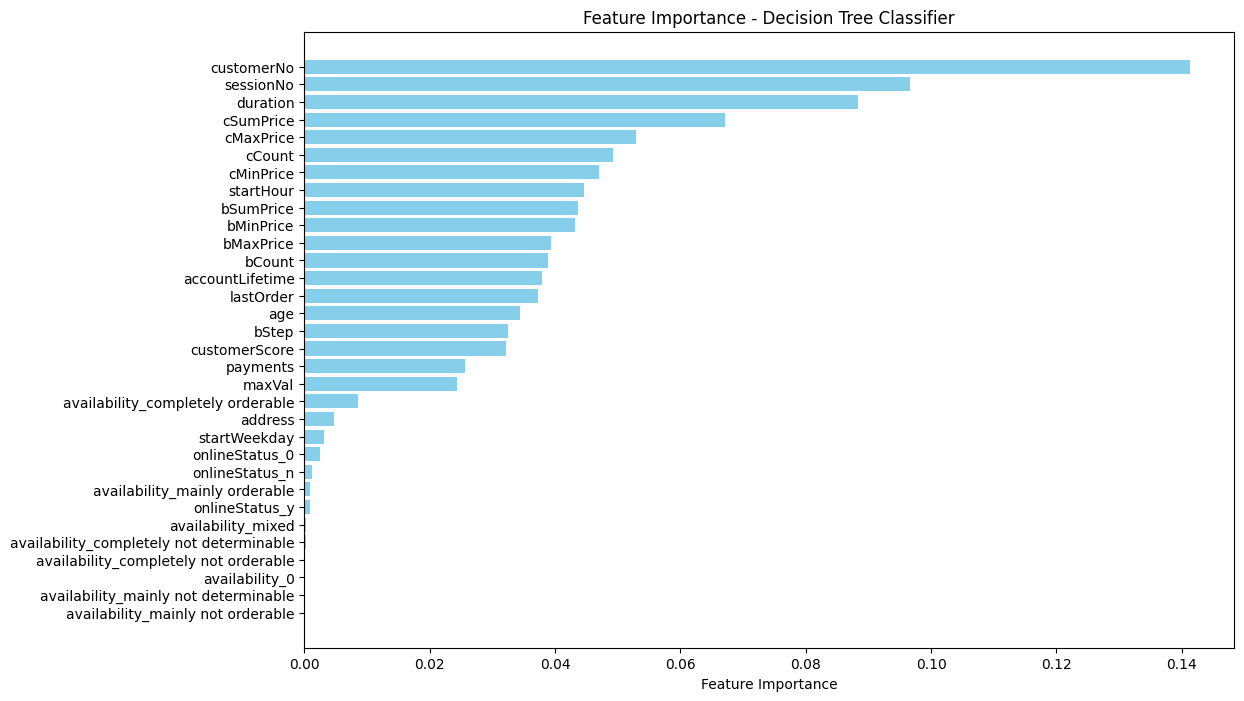

In [ ]:
# Feature Importance Decision Tree
feature_importance = DT.feature_importances_

# Urutkan fitur berdasarkan importance
feature_names = X.columns.tolist()
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance - Decision Tree Classifier")
plt.gca().invert_yaxis()  # Membalik urutan fitur agar fitur penting di atas
plt.show()

Berdasarkan ranking kinerja fitur diatas, dapat disimpulkan bahwa :
- customerNo memiliki pengaruh terbesar terhadap hasil prediksi, menunjukkan identitas pelanggan sangat penting dalam model Decision Tree.
- sessionNo dan duration merupakan fitur penting lainnya, mencerminkan pengaruh interaksi spesifik dan durasi sesi terhadap hasil.
- Fitur terkait harga seperti cSumPrice dan cMaxPrice juga signifikan, menunjukkan relevansi nilai transaksi terhadap prediksi.

**3. Feature Importance dari model Random Forest**

Berikut ranking kinerja fitur dari model Random Forest

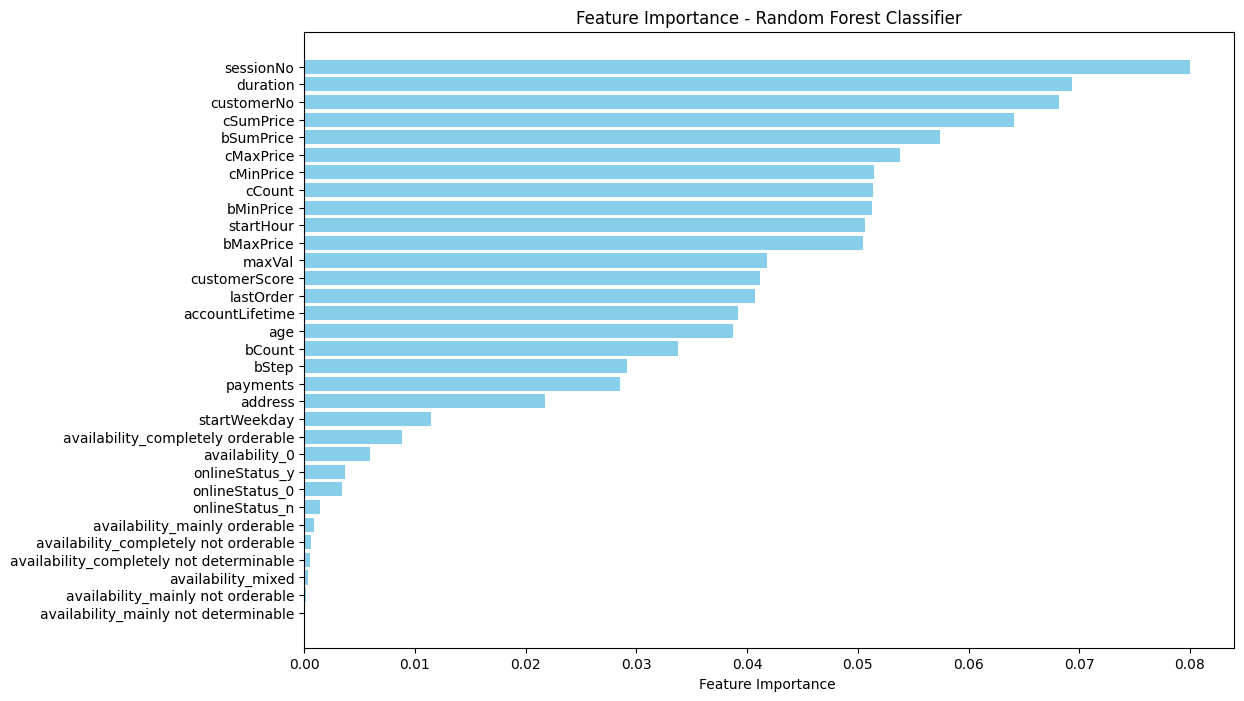

In [455]:
# Feature importance Random Forest
# Ambil feature importance
feature_importance = RF.feature_importances_

# Urutkan fitur berdasarkan importance
feature_names = X.columns.tolist()
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel("Feature Importance ")
plt.title("Feature Importance - Random Forest Classifier")
plt.gca().invert_yaxis()  # Membalik urutan fitur agar fitur penting di atas
plt.show()

Berdasarkan ranking kinerja fitur diatas, dapat disimpulkan bahwa :
- sessionNo dan duration adalah fitur paling signifikan, menunjukkan bahwa interaksi sesi dan durasi sesi memengaruhi prediksi secara dominan.
- customerNo dan fitur terkait harga seperti cSumPrice dan bSumPrice memiliki pengaruh penting, mencerminkan dampaknya pada keputusan pembelian.
- Fitur-fitur lainnya, seperti startHour dan bMinPrice, juga relevan tetapi dengan tingkat kepentingan yang lebih rendah dibandingkan fitur utama.

**4. Feature Importance dari model XGBoost**

Berikut ranking kinerja fitur dari model XGBoost

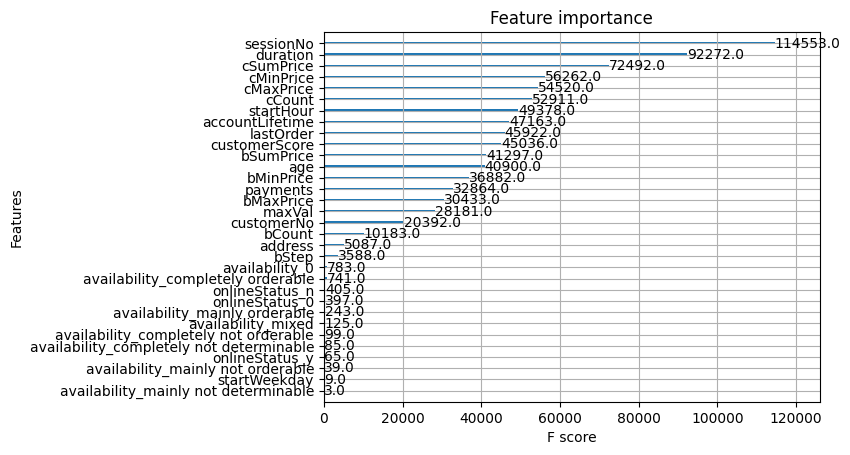

In [456]:
# Feature importance XGB
plot_importance(XGB)  # Menampilkan 10 fitur teratas
plt.show()

Berdasarkan ranking kinerja fitur diatas, dapat disimpulkan bahwa :
- sessionNo dan duration adalah fitur paling signifikan, menunjukkan bahwa interaksi sesi dan durasi sesi memengaruhi prediksi secara dominan.
- Fitur terkait harga seperti cSumPrice, cMinPrice, dan cMaxPrice juga signifikan, menunjukkan relevansi nilai transaksi terhadap prediksi.
- Fitur-fitur lainnya, seperti startHour, accountLifetime, dan cCount juga relevan tetapi dengan tingkat kepentingan yang lebih rendah dibandingkan fitur utama.

In [457]:
X_train = X_train.drop(columns=['sessionNo', 'startWeekday', 'cSumPrice', 'bSumPrice', 'bStep',
                                'customerNo', 'maxVal', 'customerScore', 'payments', 'address', 
                                'lastOrder', 'availability_completely not determinable', 
                                'availability_completely not orderable', 'availability_completely orderable', 
                                'availability_mainly not determinable', 'availability_mainly not orderable', 
                                'availability_mainly orderable', 'availability_mixed',  'availability_0', 'onlineStatus_n', 'onlineStatus_y', 'onlineStatus_0'])

X_test = X_test.drop(columns=['sessionNo', 'startWeekday', 'cSumPrice', 'bSumPrice', 'bStep',
                              'customerNo', 'maxVal', 'customerScore', 'payments', 'address', 
                              'lastOrder', 'availability_completely not determinable', 
                              'availability_completely not orderable', 'availability_completely orderable', 
                              'availability_mainly not determinable', 'availability_mainly not orderable', 
                              'availability_mainly orderable', 'availability_mixed', 'availability_0', 'onlineStatus_n', 'onlineStatus_y', 'onlineStatus_0'])

Penjelasan dan alasan mengapa kami mendrop beberapa kolom diatas, yaitu :
- sessionNo : Kolom ini tidak memberikan informasi yang relevan untuk model prediksi.
- startWeekday : Hari dalam seminggu tidak signifikan terhadap variabel target, terutama jika tidak ada pola yang jelas terkait aktivitas tertentu pada hari tertentu.
- cSumPrice : Total harga kumulatif mungkin terlalu spesifik atau berkorelasi tinggi dengan kolom lain, sehingga keberadaannya bisa menyebabkan redundansi.
- bSumPrice : Sama seperti cSumPrice, ini juga kemungkinan bersifat kumulatif atau hasil agregasi yang sudah tercakup dalam kolom lain.
- bStep : Jika ini terkait langkah-langkah tertentu yang dilakukan dalam sesi, mungkin terlalu granular atau tidak relevan untuk prediksi yang lebih general.
- customerNo : Nomor pelanggan adalah informasi identitas yang unik. Biasanya, ini tidak digunakan karena tidak berkontribusi pada pola yang bisa dipelajari model.
- maxVal : nilai maksimum dari variabel lain, akan redundant atau hanya menambah kompleksitas tanpa memberikan informasi baru.
- customerScore : Skor pelanggan tidak relevan jika sudah ada kolom lain yang lebih representatif mengenai perilaku pelanggan.
- payments : Metode atau jumlah pembayaran tidak memengaruhi variabel target secara langsung.
- address : Alamat pelanggan sering kali terlalu spesifik dan tidak memberikan kontribusi signifikan pada prediksi.
- lastOrder : Waktu atau tanggal pesanan terakhir tidak relevan, terutama jika tidak ada korelasi langsung dengan target variabel.
- availability_completely not determinable : Kolom ini terlalu spesifik dan dapat digantikan oleh variabel yang lebih umum.
- availability_completely not orderable : Kolom ini terlalu spesifik dan dapat digantikan oleh variabel yang lebih umum.
- availability_completely orderable : Jika sudah ada kolom lain yang menjelaskan ketersediaan, ini bisa redundant.
- availability_mainly not determinable : Mirip dengan kolom lain yang terkait ketersediaan, granularitas ini mungkin tidak perlu.
- availability_mainly not orderable : Informasi ini bisa tercakup dalam kolom yang lebih umum.
- availability_mainly orderable : Informasi ini bisa tercakup dalam kolom yang lebih umum.
- availability_mixed : Terlalu spesifik dan dapat digabung dengan variabel lain yang lebih general.
- availability_0 : Variabel dummy yang mungkin tidak relevan atau sudah dicakup oleh kombinasi variabel lain.
- nlineStatus_n : Variabel kategori yang menunjukkan status online bisa di-drop jika tidak ada hubungan signifikan dengan target.
- onlineStatus_y : Variabel kategori yang menunjukkan status online bisa di-drop jika tidak ada hubungan signifikan dengan target.
- onlineStatus_0 : Variabel tambahan untuk status online yang juga bisa redundant jika sudah tercakup dalam analisis lain.

### 3. Data Training 2

Model yang digunakan adalah XGBoost. Dipilih karena memiliki tingkat akurasi yang paling tinggi dibandingkan model lain.

In [458]:
# Menjalankan XGBoost
# Hitung jumlah kelas
num_classes = len(np.unique(Y_train))

XGB = XGBClassifier(n_estimators=100, max_depth=30, learning_rate=0.1, random_state=6)

XGB.fit(X_train, Y_train)
Y_pred = XGB.predict(X_test)
acc_XGB = accuracy_score(Y_test, Y_pred)

# Mencetak hasil dari XGBoost
print("Akurasi {}".format(acc_XGB))
print(classification_report(Y_test, Y_pred))

Akurasi 0.9365756442082445
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     27770
           1       0.94      0.97      0.95     58033

    accuracy                           0.94     85803
   macro avg       0.93      0.92      0.93     85803
weighted avg       0.94      0.94      0.94     85803



**Feature Importance dari model XGBoost**

Berikut ranking kinerja fitur dari model XGBoost setelah di drop beberapa fitur

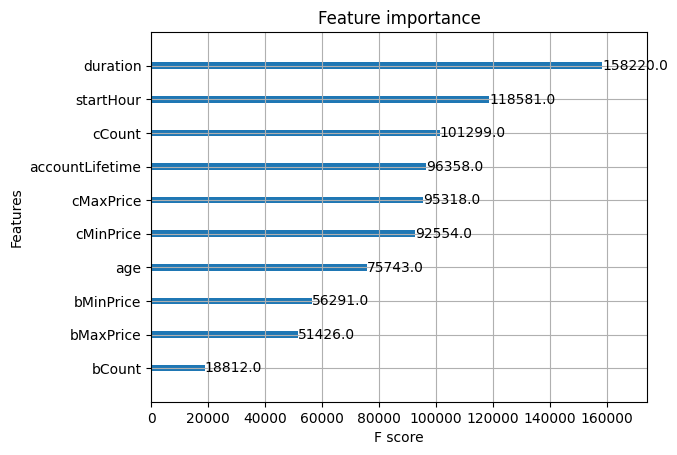

In [459]:
# Feature importance XGB
plot_importance(XGB)  # Menampilkan 10 fitur teratas
plt.show()

In [ ]:
# Memuat data final untuk perbandingan
final_prediction = pd.read_csv('DMC 2013_realclass_task1/realclass_t1.txt', delimiter='|')  # Memuat data sebenarnya
final_prediction = final_prediction['prediction']  # Ambil kolom prediksi asli untuk perhitungan log loss

# skala fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Load data klasifikasi (data pengujian)
test_data = pd.read_csv('transact_class.txt', delimiter='|')
session_numbers = test_data['sessionNo']

# Preproses data pengujian serupa dengan data latih
test_data.replace('?', np.nan, inplace=True)
test_data.fillna(0, inplace=True)  # Gantikan NaN dengan nilai 0
X_test = test_data.drop(columns=['sessionNo'])
X_test = X_test.drop(columns=['startWeekday', 'cSumPrice', 'bSumPrice', 'bStep','customerNo', 'maxVal', 'customerScore', 'payments', 
                              'address', 'lastOrder', 'availability', 'onlineStatus'])

# Konversi kolom ke tipe numerik dan isi NaN dengan 0
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = scaler.fit_transform(X_test)  # Standarisasi data pengujian

# Prediksi probabilitas untuk data pengujian
predictions_proba = XGB.predict(X_test)


temp = pd.DataFrame({
    'sessionNo': session_numbers,  # Nomor sesi yang ada di data pengujian
    'prediction': predictions_proba  # Probabilitas prediksi dari model pertama
})
temp = temp.groupby('sessionNo', as_index=False).mean()

predictions_proba = temp['prediction']  # Prediksi dari model pertama

final_prediction = pd.read_csv('DMC 2013_realclass_task1/realclass_t1.txt', delimiter='|')  # Memuat data sebenarnya
final_prediction = final_prediction['prediction']  # Ambil kolom prediksi asli untuk perhitungan log loss

predictions_proba = predictions_proba.astype(int)
acc_final = accuracy_score(final_prediction.apply(pd.to_numeric, errors='coerce'), predictions_proba)

print(f"Final Score : {acc_final}")
# print(type(predictions_proba))

# Menyimpan hasil prediksi yang sudah dipilih dalam format CSV
output = pd.DataFrame({
    'sessionNo': session_numbers,  # Nomor sesi
    'prediction': predictions_proba  # Prediksi yang dipilih
})

# Menyimpan prediksi ke dalam file CSV dengan pemisah '|' dan tanpa menyertakan indeks
output.to_csv('teamname_task1.txt', sep='|', index=False, header=True)

Final Score : 0.545294462923107



Final Score merupakan akurasi akhir yang dicapai oleh model prediksi setelah melalui proses pelatihan dan pengujian menggunakan data yang tersedia. Dalam kasus ini, model berhasil mencapai tingkat akurasi sebesar 54% saat diuji dengan dataset validasi, yaitu file "realclass_t1.txt".

Hal ini menunjukkan bahwa model mampu memprediksi dengan benar sebanyak 54% dari total data validasi. Meskipun hasil ini belum optimal, akurasi tersebut mencerminkan sejauh mana fitur-fitur yang digunakan dapat menggambarkan pola dalam data.